-- Vorgänger "foreground2.ipynb"

# Zusammenfassung: Single-Cell RNA-seq Analyse von Spermien-Differenzierung

Dieses Notebook führt eine umfassende Analyse von Single-Cell RNA-seq Daten durch, die sich auf die Spermatogenese (Spermienentwicklung) konzentriert:

## Hauptschritte:
1. **Datenvorverarbeitung**: Laden und Filtern der Rohdaten (722K Zellen, 22K Gene)
2. **Expressionsgruppen-Analyse**: Klassifizierung der Zellen in HIGH/LOW Expression basierend auf Spermien-Markergenen
3. **Trajectory-Analyse**: Identifizierung der Spermatogenese-Stadien (Spermatogonien → Spermatozyten → Spermatiden → reife Spermien)
4. **Pathway-Analyse (GSEA)**: Funktionale Anreicherungsanalyse zur Identifizierung biologischer Prozesse
5. **Netzwerk-Analyse**: Visualisierung von Gen-Pathway-Verbindungen

## Wichtige Erkenntnisse:
- **Biologisch korrekte Verteilung**: 65% späte Spermatiden, 12% reife Spermien (entspricht der Biologie)
- **Hauptpathways**: RNA-Prozessierung, Protein-Ubiquitinierung, Chromatin-Organisation
- **Negative Scores sind normal**: Sie zeigen Zellen unter dem Populationsdurchschnitt an

## Methoden:
- Scanpy für Single-Cell-Analyse
- GSEApy für Pathway-Enrichment  
- Leiden-Clustering und UMAP-Visualisierung
- Kontinuierliche Progression-Scores für Entwicklungsstadien

-- Nachfolder "gene-pathway-anaylsis.ipynb"

# 1. PREPROCESSING

## 1.1. imports

In [29]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import gseapy as gp
import scanpy as sc
import networkx as nx
import scrublet as scr #für die doublet entfernung

In [3]:
gp.__version__


'1.1.9'

## 1.2. load emptydrops adata

In [11]:
#data_pfad = "data/emptydrops_all_detected_cells.h5ad"
#data_pfad = "data/filtered_feature_bc_matrix.h5"
background = "data/raw_feature_bc_matrix.h5"
foreground = "data/pyED_correct_soupx.h5ad"

In [12]:
# Load EmptyDrops filtered data instead of the demo data
# if data_pfad last part is .h5ad, load as h5ad, otherwise as h5
if background.endswith(".h5ad"):
    bdata = sc.read_h5ad(background)
else:
    bdata = sc.read_10x_h5(background)

if foreground.endswith(".h5ad"):
    fdata = sc.read_h5ad(foreground)
else:
    fdata = sc.read_10x_h5(foreground)


# only filter gex data 
bdata = bdata[:, bdata.var.feature_types == 'Gene Expression']

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
print(bdata)
print(fdata)

View of AnnData object with n_obs × n_vars = 722431 × 22040
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
AnnData object with n_obs × n_vars = 8202 × 22037
    uns: 'X_name'


In [15]:
# Make background a real background by removing foreground cells from it

# Remove cells that are present in fdata from bdata
cells_to_remove = fdata.obs_names
bdata = bdata[~bdata.obs_names.isin(cells_to_remove)].copy()

print(bdata)
print(fdata)

AnnData object with n_obs × n_vars = 714229 × 22040
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
AnnData object with n_obs × n_vars = 8202 × 22037
    uns: 'X_name'


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## 1.3. analyse adata

In [21]:
bdata.obs.head()


""
AAACAGCCAAACAACA-1
AAACAGCCAAACATAG-1
AAACAGCCAAACCCTA-1
AAACAGCCAAACCTAT-1
AAACAGCCAAACCTTG-1


In [22]:
bdata.var.head()

,gene_ids,feature_types,genome,interval
ALDH1A1,ENSSSCG00000028996,Gene Expression,Sscrofa11_1,1:226217290-226217308
ANXA1,ENSSSCG00000005267,Gene Expression,Sscrofa11_1,1:226414305-226414307
RORB,ENSSSCG00000005268,Gene Expression,Sscrofa11_1,1:227574647-227694207
TRPM6,ENSSSCG00000005269,Gene Expression,Sscrofa11_1,1:227962757-227963309
C9orf40,ENSSSCG00000031382,Gene Expression,Sscrofa11_1,1:228045012-228045013


In [23]:
print(bdata.X[0])


  (np.int32(0), np.int32(1768))	7.601402282714844
  (np.int32(0), np.int32(2699))	7.601402282714844
  (np.int32(0), np.int32(9238))	7.601402282714844
  (np.int32(0), np.int32(17302))	7.601402282714844
  (np.int32(0), np.int32(18332))	7.601402282714844


In [19]:
adata.layers['counts'] = adata.X  # Save raw counts


NameError: name 'adata' is not defined

## 1.4. normalize + log 
(needed otherwise i get the result of just 1 HIGH and 12000 LOW buckets, the same result as when just using the total_umi count)

In [20]:
# preprocessing
sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)

sc.pp.normalize_total(fdata, target_sum=1e4)
sc.pp.log1p(fdata)
#adata.layers['lognorm'] = adata.X


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [ ]:
bdata.obs.head()


""
AAACAGCCAAACAACA-1
AAACAGCCAAACATAG-1
AAACAGCCAAACCCTA-1
AAACAGCCAAACCTAT-1
AAACAGCCAAACCTTG-1


## 1.4.2. Doublet entfernung

In [24]:
print(f"Gesamtzellen: {bdata.shape[0]}")
print(f"Durchschnittliche Gene pro Zelle: {np.mean(bdata.X.sum(axis=1))}")

Gesamtzellen: 714229
Durchschnittliche Gene pro Zelle: 46.00505828857422


In [14]:
""" # scrublet auf raw counts (muss im .raw liegen!)
if adata.raw is None:
    adata.raw = adata

scrub = scr.Scrublet(
    adata.raw.X,
    expected_doublet_rate=0.15,
    sim_doublet_ratio=3.0
)

doublet_scores, predicted_doublets = scrub.scrub_doublets(
    synthetic_doublet_umi_subsampling=1.0,
    use_approx_neighbors=False
)

plt.figure(figsize=(10, 5))
scrub.plot_histogram()
plt.title('Doublet Score Distribution')
plt.show()

print(f"Automatischer Threshold: {scrub.threshold_:.3f}")
threshold = 0.40
predicted_doublets = doublet_scores > threshold
mean_doublet_score = doublet_scores[predicted_doublets].mean()
print(f"Mittlerer Score der entfernten Doublets: {mean_doublet_score:.2f}")

print(f"Entferne {predicted_doublets.sum()} Doublets ({predicted_doublets.mean()*100:.1f}%)")
adata = adata[~predicted_doublets, :].copy()

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(doublet_scores, bins=50, color='blue', alpha=0.7, label='Observed Cells')
plt.axvline(x=scrub.threshold_, color='red', linestyle='--',
            linewidth=2, label=f'Auto Threshold: {scrub.threshold_:.2f}')
plt.axvline(x=threshold, color='green', linestyle='-',
            linewidth=2, label=f'Manual Threshold: {threshold:.2f}')
plt.xlabel('Doublet Score')
plt.ylabel('Count')
plt.title('Doublet Score Distribution with Thresholds')
plt.legend()
plt.show() """

' # scrublet auf raw counts (muss im .raw liegen!)\nif adata.raw is None:\n    adata.raw = adata\n\nscrub = scr.Scrublet(\n    adata.raw.X,\n    expected_doublet_rate=0.15,\n    sim_doublet_ratio=3.0\n)\n\ndoublet_scores, predicted_doublets = scrub.scrub_doublets(\n    synthetic_doublet_umi_subsampling=1.0,\n    use_approx_neighbors=False\n)\n\nplt.figure(figsize=(10, 5))\nscrub.plot_histogram()\nplt.title(\'Doublet Score Distribution\')\nplt.show()\n\nprint(f"Automatischer Threshold: {scrub.threshold_:.3f}")\nthreshold = 0.40\npredicted_doublets = doublet_scores > threshold\nmean_doublet_score = doublet_scores[predicted_doublets].mean()\nprint(f"Mittlerer Score der entfernten Doublets: {mean_doublet_score:.2f}")\n\nprint(f"Entferne {predicted_doublets.sum()} Doublets ({predicted_doublets.mean()*100:.1f}%)")\nadata = adata[~predicted_doublets, :].copy()\n\nplt.figure(figsize=(10, 5))\nn, bins, patches = plt.hist(doublet_scores, bins=50, color=\'blue\', alpha=0.7, label=\'Observed Cells

In [15]:
adata.shape

(722431, 22040)

## 1.5. check avaible variables

In [16]:
print("Available observation variables:")
print(f"Total columns: {len(adata.obs.columns)}")
print(f"Column names: {list(adata.obs.columns)}")
print()

for col in adata.obs.columns:
    print(f"\nColumn: {col}")
    print(f"  Data type: {adata.obs[col].dtype}")
    print(f"  Number of unique values: {adata.obs[col].nunique()}")
    
    if adata.obs[col].dtype == 'object' or adata.obs[col].dtype.name == 'category':
        unique_vals = adata.obs[col].unique()
        if len(unique_vals) <= 10:
            print(f"  Unique values: {unique_vals}")
        else:
            print(f"  First 10 unique values: {unique_vals[:10]}")
    else:
        # For numeric columns, show some basic stats
        print(f"  Min: {adata.obs[col].min()}, Max: {adata.obs[col].max()}")
        if adata.obs[col].nunique() <= 20:  # Show unique values if not too many
            print(f"  Unique values: {sorted(adata.obs[col].unique())}")

Available observation variables:
Total columns: 0
Column names: []



## 1.6. create grouping variables

In [28]:
import numpy as np
import pandas as pd
import anndata

# Create the input_adata object (for example, by reading from file)
input_adata = sc.read_10x_h5("data/raw_feature_bc_matrix.h5")

# Subset background (LOW) and foreground (HIGH) from input_adata
bdata = input_adata[input_adata.obs['expression_group'] == "LOW"].copy()
fdata = input_adata[input_adata.obs['expression_group'] == "HIGH"].copy()

# Re-create the expression_group column in input_adata with correct categorical ordering, based on bdata and fdata indices
# Set foreground (HIGH) first, background (LOW) second for ordering in concatenation & categories
input_adata.obs['expression_group'] = pd.Categorical(
    ["HIGH" if idx in fdata.obs_names else "LOW" for idx in input_adata.obs_names],
    categories=["LOW", "HIGH"],
    ordered=True
)

print(f"Foreground (HIGH) shape: {fdata.shape}")
print(f"Background (LOW) shape: {bdata.shape}")
print(f"Combined input_adata shape: {input_adata.shape}")


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


KeyError: 'expression_group'

In [21]:
# Subset data for analysis (optional - you can use the full dataset)
# This is similar to the original example that subset to "CD14 Mono" cells
# You might want to subset based on specific criteria relevant to your data

# For demonstration, we'll use all data (modify if you want to subset)
bdata = adata.copy()
print(f"Analysis data shape: {bdata.shape}")


Analysis data shape: (722431, 22040)


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [22]:
adata.obs.head()


,expression_group
GGGATTAAGTTACCGG-1,HIGH
TAGGTTGGTAACCACA-1,HIGH
GGATTGCGTGGTGAGA-1,HIGH
AATTGGGAGATGGAGC-1,HIGH
GCTCAACCACAAAGCG-1,HIGH


# 2. GSEA ANALYSIS

## 2.1. choose gene_set library

In [ ]:
names = gp.get_library_name()
for name in sorted(names):
    print(name)

ARCHS4_Cell-lines
ARCHS4_IDG_Coexp
ARCHS4_Kinases_Coexp
ARCHS4_TFs_Coexp
ARCHS4_Tissues
Achilles_fitness_decrease
Achilles_fitness_increase
Aging_Perturbations_from_GEO_down
Aging_Perturbations_from_GEO_up
Allen_Brain_Atlas_10x_scRNA_2021
Allen_Brain_Atlas_down
Allen_Brain_Atlas_up
Azimuth_2023
Azimuth_Cell_Types_2021
BioCarta_2013
BioCarta_2015
BioCarta_2016
BioPlanet_2019
BioPlex_2017
CCLE_Proteomics_2020
COMPARTMENTS_Curated_2025
COMPARTMENTS_Experimental_2025
CORUM
COVID-19_Related_Gene_Sets
COVID-19_Related_Gene_Sets_2021
Cancer_Cell_Line_Encyclopedia
CellMarker_2024
CellMarker_Augmented_2021
ChEA_2013
ChEA_2015
ChEA_2016
ChEA_2022
Chromosome_Location
Chromosome_Location_hg19
ClinVar_2019
DGIdb_Drug_Targets_2024
DSigDB
Data_Acquisition_Method_Most_Popular_Genes
DepMap_CRISPR_GeneDependency_CellLines_2023
DepMap_WG_CRISPR_Screens_Broad_CellLines_2019
DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
Descartes_Cell_Types_and_Tissue_2021
Diabetes_Perturbations_GEO_2022
DisGeNET
Disease_

: 

## 2.2. gsea analysis

In [ ]:
t1 = time.time()
# NOTE: To speed up, use gp.prerank (with  own ranked list.)
res = gp.gsea(data=bdata.to_df().T,  # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2025",
        cls=bdata.obs.expression_group,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n',  # signal_to_noise
        threads=16)
t2 = time.time()
print(f"GSEA completed in {t2-t1:.2f} seconds")


In [ ]:
res.res2d.head(10)


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Ubiquitin-Dependent Protein Catabolic Process ...,0.533989,2.711016,0.0,0.0,0.0,197/388,26.49%,FAF1;UBR3;PSMC6;FBXL17;UBR5;GSK3B;RNF216;FBXW7...
1,gsea,Proteasome-Mediated Ubiquitin-Dependent Protei...,0.549752,2.709803,0.0,0.0,0.0,141/290,23.09%,FAF1;UBR3;PSMC6;FBXL17;UBR5;GSK3B;RNF216;FBXW7...
2,gsea,mRNA Stabilization (GO:0048255),0.668532,2.630084,0.0,0.0,0.0,24/47,15.98%,QKI;RBM47;LARP1;CSDE1;IREB2;TAF15;ELAVL4;TARDB...
3,gsea,Proteasomal Protein Catabolic Process (GO:0010...,0.521145,2.626959,0.0,0.0,0.0,171/319,30.52%,FAF1;PSMC6;PSME4;FBXL17;UBR5;GSK3B;RNF216;FBXW...
4,gsea,Protein Modification by Small Protein Conjugat...,0.521957,2.622329,0.0,0.0,0.0,153/285,30.36%,UBR3;FBXL17;FBXW7;PIAS1;NFE2L2;MDM4;FBXL5;BIRC...
5,gsea,Modification-Dependent Protein Catabolic Proce...,0.539894,2.604469,0.0,0.0,0.0,114/190,31.45%,UBR3;UBE3A;UBE4B;CNOT4;RNF144A;HERC4;ITCH;KLHL...
6,gsea,Protein Ubiquitination (GO:0016567),0.502766,2.599451,0.0,0.0,0.0,176/340,30.29%,UBR3;FBXL17;UBR5;TANK;FBXW7;UBE3A;NFE2L2;MDM4;...
7,gsea,RNA Processing (GO:0006396),0.55815,2.588299,0.0,0.0,0.0,182/259,33.43%,RSRC1;HNRNPA2B1;SON;RBM6;LUC7L3;CELF1;RNGTT;TE...
8,gsea,Intracellular Protein Transport (GO:0006886),0.522142,2.586554,0.0,0.0,0.0,171/294,30.80%,AP3B1;KPNA1;RANBP17;ARFIP1;USO1;TNPO3;MAP4K5;K...
9,gsea,Gene Expression (GO:0010467),0.559898,2.582317,0.0,0.0,0.0,174/316,25.12%,MEF2A;HNRNPA2B1;RBM6;AGFG1;THOC1;RNGTT;HNRNPDL...


## 2.3. heatmap

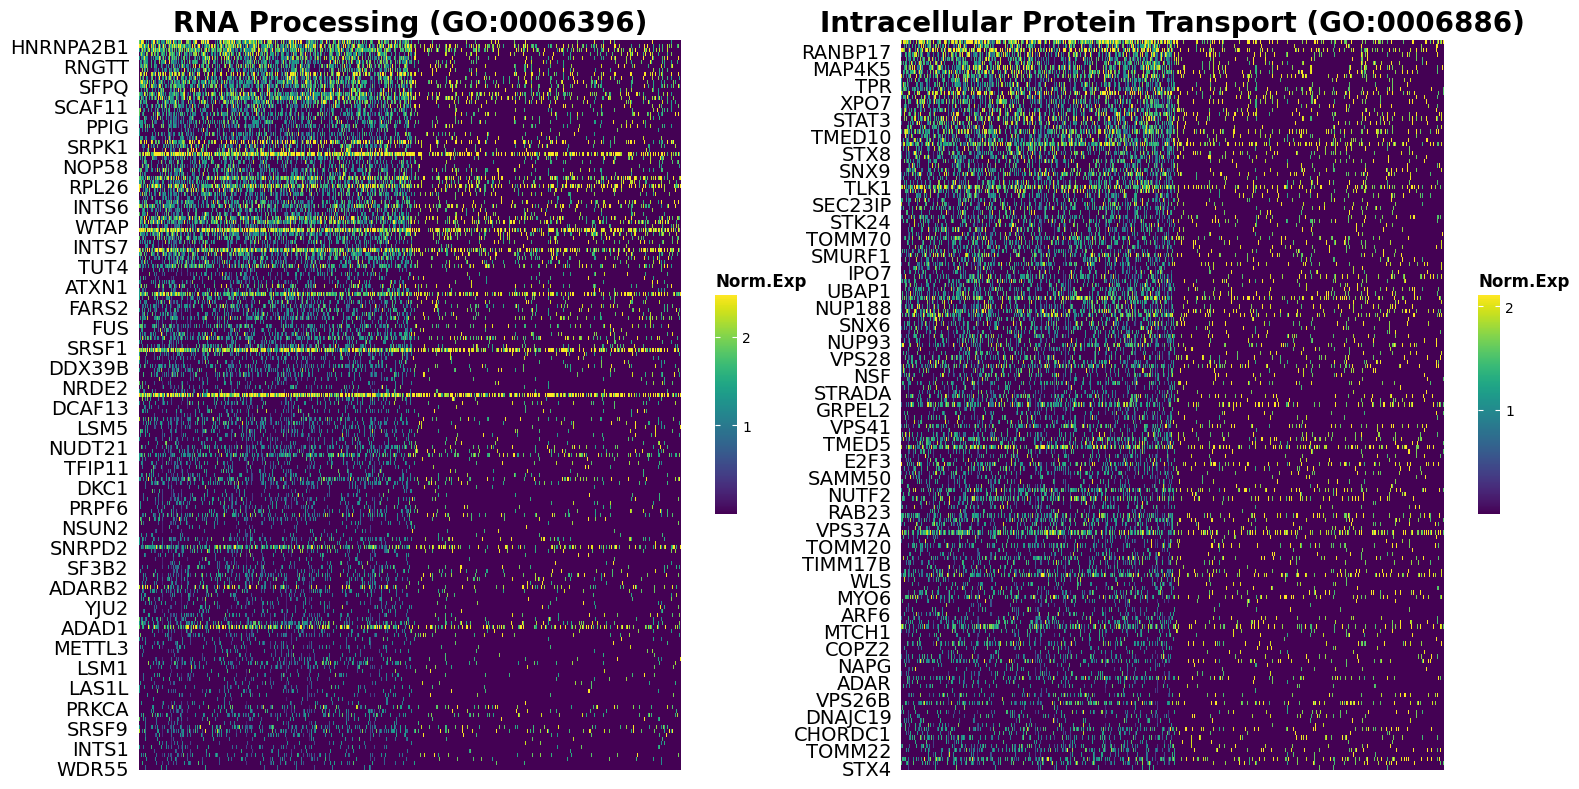

In [ ]:
liste = [7, 8]
zeilenanzahl = len(liste)//2
fig, axes = plt.subplots(zeilenanzahl, 2, figsize=(16, 8*zeilenanzahl))
axes = axes.flatten()

for idx, i in enumerate(liste):
    genes = res.res2d.Lead_genes.iloc[i].split(";")
    ax = gp.heatmap(df = res.heatmat.loc[genes],
               z_score=None,
               title=res.res2d.Term.iloc[i],
               figsize=None,
               cmap=plt.cm.viridis,
               xticklabels=False,
               ax=axes[idx])

plt.tight_layout()
plt.show()

## 2.4. enrichement plot

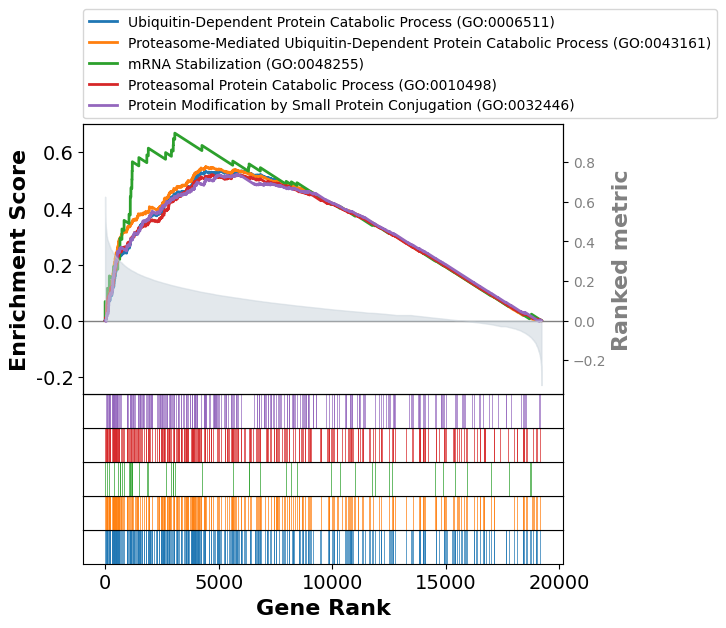

In [ ]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:5])

# 3. DEG Analysis

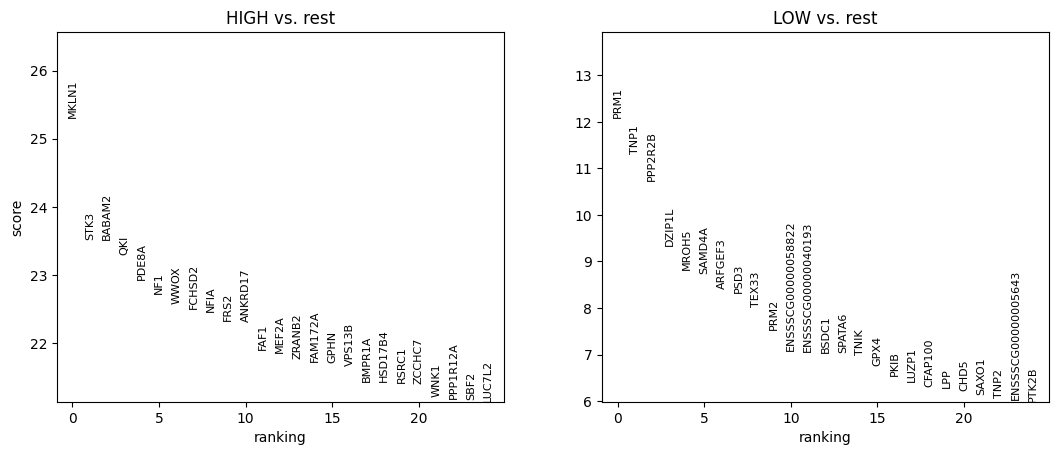

In [ ]:
# find degs
sc.tl.rank_genes_groups(bdata,
                        groupby='expression_group',
                        use_raw=False,
                        method='wilcoxon',
                        n_genes=25
                        )

# visualis the top 25 differentially expressed genes
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False, figsize=(12, 8))

# safe for later analysis in 4. over-representaition analysis
deg_results_fixed = sc.get.rank_genes_groups_df(bdata, group=None)

In [ ]:
# get deg result
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

#print
degs.head()

,HIGH_names,HIGH_scores,HIGH_pvals,HIGH_pvals_adj,HIGH_logfoldchanges,LOW_names,LOW_scores,LOW_pvals,LOW_pvals_adj,LOW_logfoldchanges
0,MKLN1,25.313354,2.277017e-141,5.018545e-137,2.806590,PRM1,12.095065,1.121537e-33,2.263616e-32,0.790076
1,STK3,23.519688,2.565395e-122,1.901617e-118,2.708164,TNP1,11.319798,1.047120e-29,1.708255e-28,0.804318
2,BABAM2,23.519308,2.588407e-122,1.901617e-118,2.588884,PPP2R2B,10.742024,6.461188e-27,9.223095e-26,2.114665
3,QKI,23.297939,4.651751e-120,2.563115e-116,2.569254,DZIP1L,9.332106,1.037886e-20,1.007266e-19,1.720723
4,PDE8A,22.923937,2.682012e-116,1.182231e-112,2.705829,MROH5,8.814241,1.204981e-18,1.035795e-17,1.950600


## 3.1. prerank

In [ ]:
gene_rank = deg_results_fixed.set_index('names')['logfoldchanges'].sort_values(ascending=False)
gene_rank.index = gene_rank.index.str.upper()

# Run prerank GSEA
prerank_res = gp.prerank(rnk=gene_rank,
                        gene_sets='GO_Biological_Process_2025',
                        min_size=5, max_size=300)

print("Prerank GSEA completed")
prerank_res.res2d.head()

Prerank GSEA completed


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Regulation of Transcription by RNA Polymerase ...,0.590909,1.470166,0.076016,0.076016,0.058,6/6,48.00%,BMPR1A;HSD17B4;NFIA;WWOX;MEF2A;PPP1R12A
1,prerank,Positive Regulation of Transcription by RNA Po...,0.590909,1.470166,0.076016,0.076016,0.058,6/6,48.00%,BMPR1A;HSD17B4;NFIA;WWOX;MEF2A;PPP1R12A
2,prerank,Positive Regulation of DNA-templated Transcrip...,0.590909,1.470166,0.076016,0.076016,0.058,6/6,48.00%,BMPR1A;HSD17B4;NFIA;WWOX;MEF2A;PPP1R12A


# 4. Over-representation analysis

In [ ]:
# check how my DEG data looks like
deg_results = sc.get.rank_genes_groups_df(bdata, group=None)
print(f"Shape of results: {deg_results.shape}")
print(f"Columns: {list(deg_results.columns)}")
print(f"Unique groups: {deg_results['group'].unique()}")
print("\nFirst 5? rows:")
print(deg_results.head())

print(f"\nP-value adjusted range: {deg_results['pvals_adj'].min()} - {deg_results['pvals_adj'].max()}")
print(f"Log fold change range: {deg_results['logfoldchanges'].min()} - {deg_results['logfoldchanges'].max()}")

Shape of results: (50, 6)
Columns: ['group', 'names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']
Unique groups: ['HIGH', 'LOW']
Categories (2, object): ['HIGH', 'LOW']

First 5? rows:
  group   names     scores  logfoldchanges          pvals      pvals_adj
0  HIGH   MKLN1  25.313354        2.806590  2.277017e-141  5.018545e-137
1  HIGH    STK3  23.519688        2.708164  2.565395e-122  1.901617e-118
2  HIGH  BABAM2  23.519308        2.588884  2.588407e-122  1.901617e-118
3  HIGH     QKI  23.297939        2.569254  4.651751e-120  2.563115e-116
4  HIGH   PDE8A  22.923937        2.705829  2.682012e-116  1.182231e-112

P-value adjusted range: 5.018545199807338e-137 - 1.0199287578639899e-08
Log fold change range: 0.4102363884449005 - 3.1893250942230225


In [ ]:
# we want to selecet significantly upregulated genes in one specific group. 
# subset up or down regulated genes

#degs_sig = degs[degs.LOW_pvals_adj < 0.05]
#degs_up = degs_sig[degs_sig.LOW_logfoldchanges > 0]
#degs_dw = degs_sig[degs_sig.LOW_logfoldchanges < 0]
#print(degs_up.shape)
#print(degs_dw.shape)
# high checken
high_group_genes = deg_results_fixed[
    (deg_results_fixed['group'] == 'HIGH') &           # Only HIGH group
    (deg_results_fixed['logfoldchanges'] > 0.5) &      # Upregulated
    (deg_results_fixed['pvals_adj'] < 0.05)            # Significant
]

print(f"Found {len(high_group_genes)} upregulated genes in HIGH group")

# und selbe spiel nochmal für low checken
low_group_genes = deg_results_fixed[
    (deg_results_fixed['group'] == 'LOW') &            # Only LOW group
    (deg_results_fixed['logfoldchanges'] > 0.5) &      # Upregulated
    (deg_results_fixed['pvals_adj'] < 0.05)            # Significant
]

print(f"Found {len(low_group_genes)} upregulated genes in LOW group")


Found 25 upregulated genes in HIGH group
Found 24 upregulated genes in LOW group


In [ ]:
enr_high = gp.enrichr(high_group_genes.names,
                    gene_sets='GO_Biological_Process_2025',
                    outdir=None,
                    organism="human")
enr_low = gp.enrichr(low_group_genes.names,
                    gene_sets='GO_Biological_Process_2025',
                    outdir=None,
                    organism="human")
                    
                    #gene_list=upregulated_genes,
                    #gene_sets='GO_Biological_Process_2025',  # Updated to 2025
                    #organism='human',  # use human for pig data
                    #outdir=None,
                    #cutoff=0.5)


In [ ]:
enr_high.res2d.Term = enr_high.res2d.Term.str.split(" \(GO").str[0]
enr_low.res2d.Term = enr_low.res2d.Term.str.split(" \(GO").str[0]

## 4.1 Dotplot

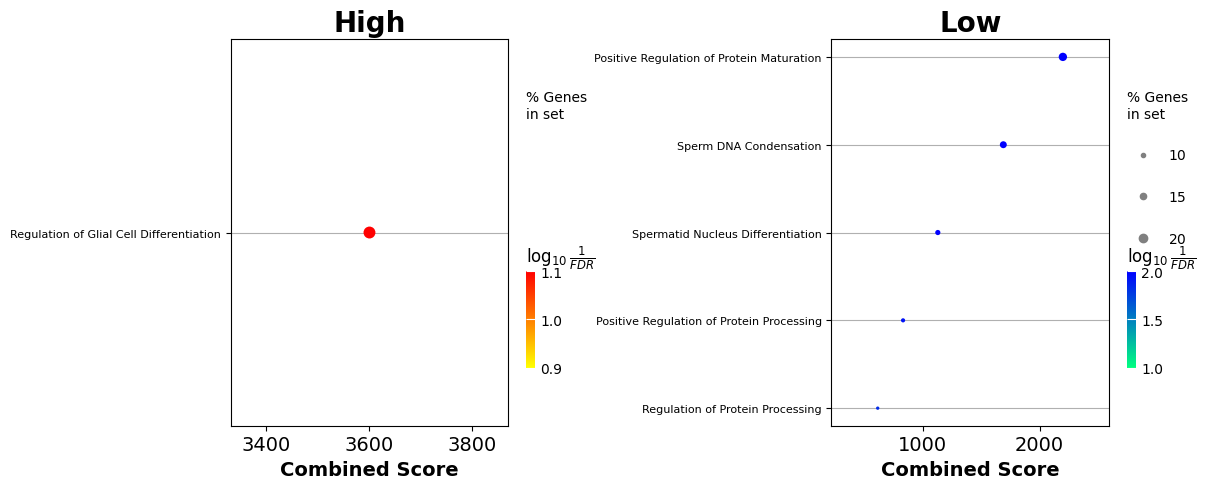

In [ ]:
# create to plots on the same row in a figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for high group
gp.dotplot(enr_high.res2d, figsize=(4,6), title="High", cmap = plt.cm.autumn_r, ax=axs[0])

# Plot for low group
gp.dotplot(enr_low.res2d, figsize=(4,6), title="Low", cmap = plt.cm.winter_r, ax=axs[1])

# make the y-axis labels smaller
axs[0].tick_params(axis='y', labelsize=8)
axs[1].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

## 4.2. concat high and low data

In [ ]:
# concat results
enr_high.res2d['GROUP'] = "HIGH"
enr_low.res2d['GROUP'] = "LOW"
enr_res = pd.concat([enr_high.res2d.head(), enr_low.res2d.head()])

print(enr_res["GROUP"].value_counts())
enr_res

GROUP
HIGH    5
LOW     5
Name: count, dtype: int64


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,GROUP
0,GO_Biological_Process_2025,Regulation of Glial Cell Differentiation,2/7,0.000031,0.013085,0,0,347.304348,3601.323532,NF1;QKI,HIGH
1,GO_Biological_Process_2025,Artery Morphogenesis,2/31,0.000682,0.079664,0,0,59.808096,436.013563,NF1;BMPR1A,HIGH
2,GO_Biological_Process_2025,Cellular Response to Growth Factor Stimulus,3/150,0.000843,0.079664,0,0,18.393321,130.207824,WWOX;PDE8A;BMPR1A,HIGH
3,GO_Biological_Process_2025,Positive Regulation of Transcription by RNA Po...,6/983,0.001099,0.079664,0,0,6.140602,41.838970,MEF2A;WWOX;PPP1R12A;NFIA;HSD17B4;BMPR1A,HIGH
4,GO_Biological_Process_2025,Myelination,2/50,0.001771,0.079664,0,0,36.099638,228.730410,NF1;SBF2,HIGH
0,GO_Biological_Process_2025,Positive Regulation of Protein Maturation,2/10,0.000062,0.008228,0,0,226.909091,2199.345383,TNP2;TNP1,LOW
1,GO_Biological_Process_2025,Sperm DNA Condensation,2/12,0.000090,0.008228,0,0,181.509091,1690.049095,TNP2;TNP1,LOW
2,GO_Biological_Process_2025,Spermatid Nucleus Differentiation,2/16,0.000164,0.009944,0,0,129.623377,1129.821941,TNP2;TNP1,LOW
3,GO_Biological_Process_2025,Positive Regulation of Protein Processing,2/20,0.000259,0.011774,0,0,100.797980,832.549579,TNP2;TNP1,LOW
4,GO_Biological_Process_2025,Regulation of Protein Processing,2/25,0.000407,0.014818,0,0,78.865613,615.663501,TNP2;TNP1,LOW


## 4.3. plot concatted data

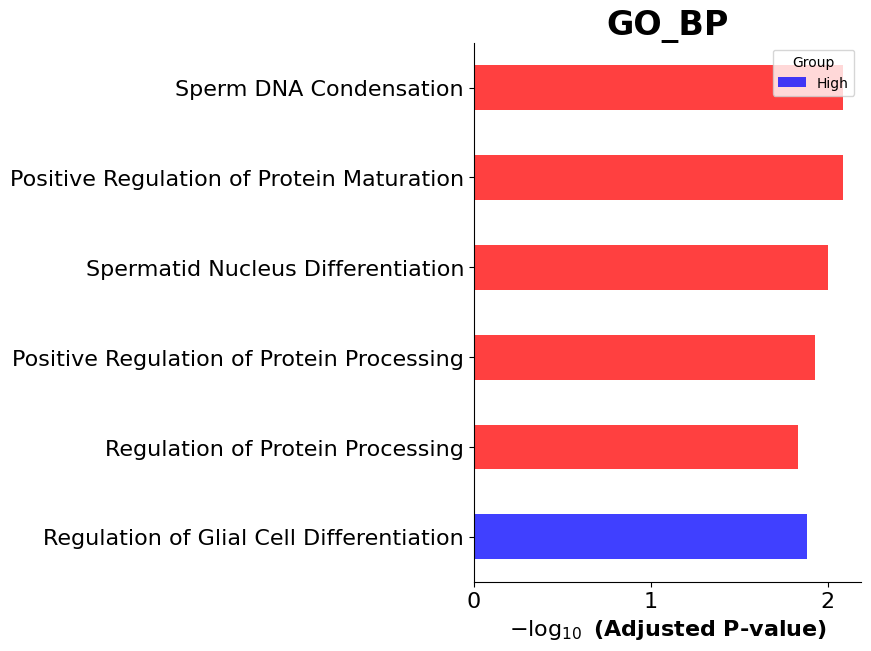

In [ ]:
ax = gp.barplot(enr_res, figsize=(5,7),
                group ='GROUP',
                title ="GO_BP",
                color = ['blue','red'])
# add legend
ax.legend(title='Group', labels=['High', 'Low'])
plt.show()

# 5. Network visualizations

In [ ]:
nodes, edges = gp.enrichment_map(res.res2d)


In [ ]:
nodes.head()


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,p_inv,Hits_ratio
node_idx,,,,,,,,,,,,
0,gsea,RNA Processing (GO:0006396),0.55815,2.588299,0.0,0.0,0.0,182/259,33.43%,RSRC1;HNRNPA2B1;SON;RBM6;LUC7L3;CELF1;RNGTT;TE...,15.65356,0.702703
1,gsea,Protein Ubiquitination (GO:0016567),0.502766,2.599451,0.0,0.0,0.0,176/340,30.29%,UBR3;FBXL17;UBR5;TANK;FBXW7;UBE3A;NFE2L2;MDM4;...,15.65356,0.517647
2,gsea,Modification-Dependent Protein Catabolic Proce...,0.539894,2.604469,0.0,0.0,0.0,114/190,31.45%,UBR3;UBE3A;UBE4B;CNOT4;RNF144A;HERC4;ITCH;KLHL...,15.65356,0.600000
3,gsea,Protein Modification by Small Protein Conjugat...,0.521957,2.622329,0.0,0.0,0.0,153/285,30.36%,UBR3;FBXL17;FBXW7;PIAS1;NFE2L2;MDM4;FBXL5;BIRC...,15.65356,0.536842
4,gsea,Proteasomal Protein Catabolic Process (GO:0010...,0.521145,2.626959,0.0,0.0,0.0,171/319,30.52%,FAF1;PSMC6;PSME4;FBXL17;UBR5;GSK3B;RNF216;FBXW...,15.65356,0.536050


In [ ]:
edges.head()


,src_idx,targ_idx,src_name,targ_name,jaccard_coef,overlap_coef,overlap_genes
0,0,4,RNA Processing (GO:0006396),Proteasomal Protein Catabolic Process (GO:0010...,0.002841,0.005848,DCAF13
1,0,5,RNA Processing (GO:0006396),mRNA Stabilization (GO:0048255),0.040404,0.333333,"HNRNPU,TARDBP,NRDE2,HNRNPD,FUS,SYNCRIP,METTL14..."
2,0,6,RNA Processing (GO:0006396),Proteasome-Mediated Ubiquitin-Dependent Protei...,0.003106,0.007092,DCAF13
3,0,7,RNA Processing (GO:0006396),Chromatin Organization (GO:0006325),0.018462,0.040268,"HNRNPU,PRMT9,PRMT1,SF3B1,SRPK1,SFPQ"
4,0,8,RNA Processing (GO:0006396),mRNA Processing (GO:0006397),0.264228,0.503876,"LSM5,TCERG1,PRMT9,SRSF1,SRRM1,WBP4,SF3B2,SNRPD..."


In [ ]:
# build graph
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

# Add missing node if there is any
for node in nodes.index:
    if node not in G.nodes():
        G.add_node(node)


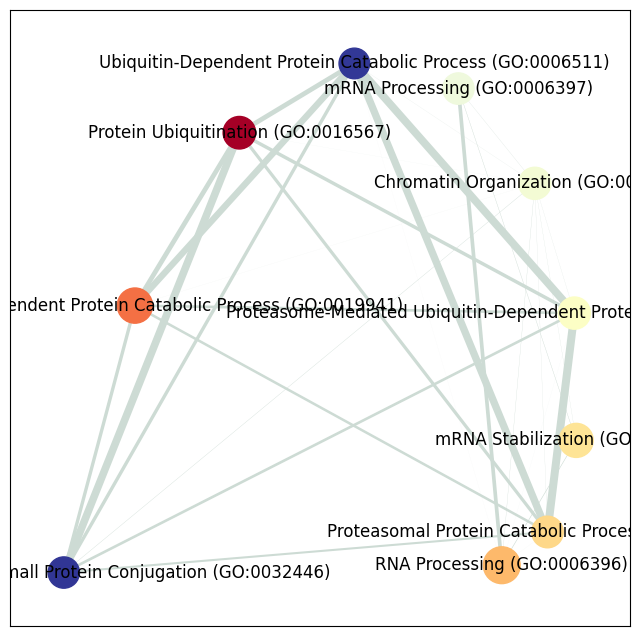

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# init node cooridnates
pos=nx.layout.spiral_layout(G)
#node_size = nx.get_node_attributes()
# draw node
nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.RdYlBu,
                       node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000))
# draw node label
nx.draw_networkx_labels(G,
                        pos=pos,
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*10, edge_weight)),
                       edge_color='#CDDBD4')
plt.show()


In [ ]:
# Perform differential expression analysis using scanpy
sc.tl.rank_genes_groups(bdata, 'expression_group', method='wilcoxon')

# Get differential expression results
de_results = sc.get.rank_genes_groups_df(bdata, group=None)
print(f"Number of genes tested: {len(de_results)}")
de_results.head()


Number of genes tested: 44080


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,HIGH,MKLN1,25.313354,2.806590,2.277017e-141,5.018545e-137
1,HIGH,STK3,23.519688,2.708164,2.565395e-122,1.901617e-118
2,HIGH,BABAM2,23.519308,2.588884,2.588407e-122,1.901617e-118
3,HIGH,QKI,23.297939,2.569254,4.651751e-120,2.563115e-116
4,HIGH,PDE8A,22.923937,2.705829,2.682012e-116,1.182231e-112


In [ ]:
# Create ranked gene list for prerank GSEA
# Use logfoldchanges as ranking metric (you can modify this)
gene_rank = de_results.set_index('names')['logfoldchanges'].sort_values(ascending=False)

print(f"Gene ranking list created with {len(gene_rank)} genes")
print(f"Top 10 upregulated genes:")
print(gene_rank.head(10))
print(f"\nTop 10 downregulated genes:")
print(gene_rank.tail(10))


Gene ranking list created with 44080 genes
Top 10 upregulated genes:
names
PLEKHG4               24.867424
ENSSSCG00000033451    24.820637
CHRNA5                24.781504
HHIPL2                24.632944
CALB2                 24.508917
TBX20                 24.491877
LRIT3                 24.469126
TMEM186               24.360195
ENSSSCG00000036554    24.355606
HDHD3                 24.206757
Name: logfoldchanges, dtype: float32

Top 10 downregulated genes:
names
HDHD3                -24.206757
ENSSSCG00000036554   -24.355606
TMEM186              -24.360195
LRIT3                -24.469126
TBX20                -24.491877
CALB2                -24.508917
HHIPL2               -24.632944
CHRNA5               -24.781504
ENSSSCG00000033451   -24.820637
PLEKHG4              -24.867424
Name: logfoldchanges, dtype: float32


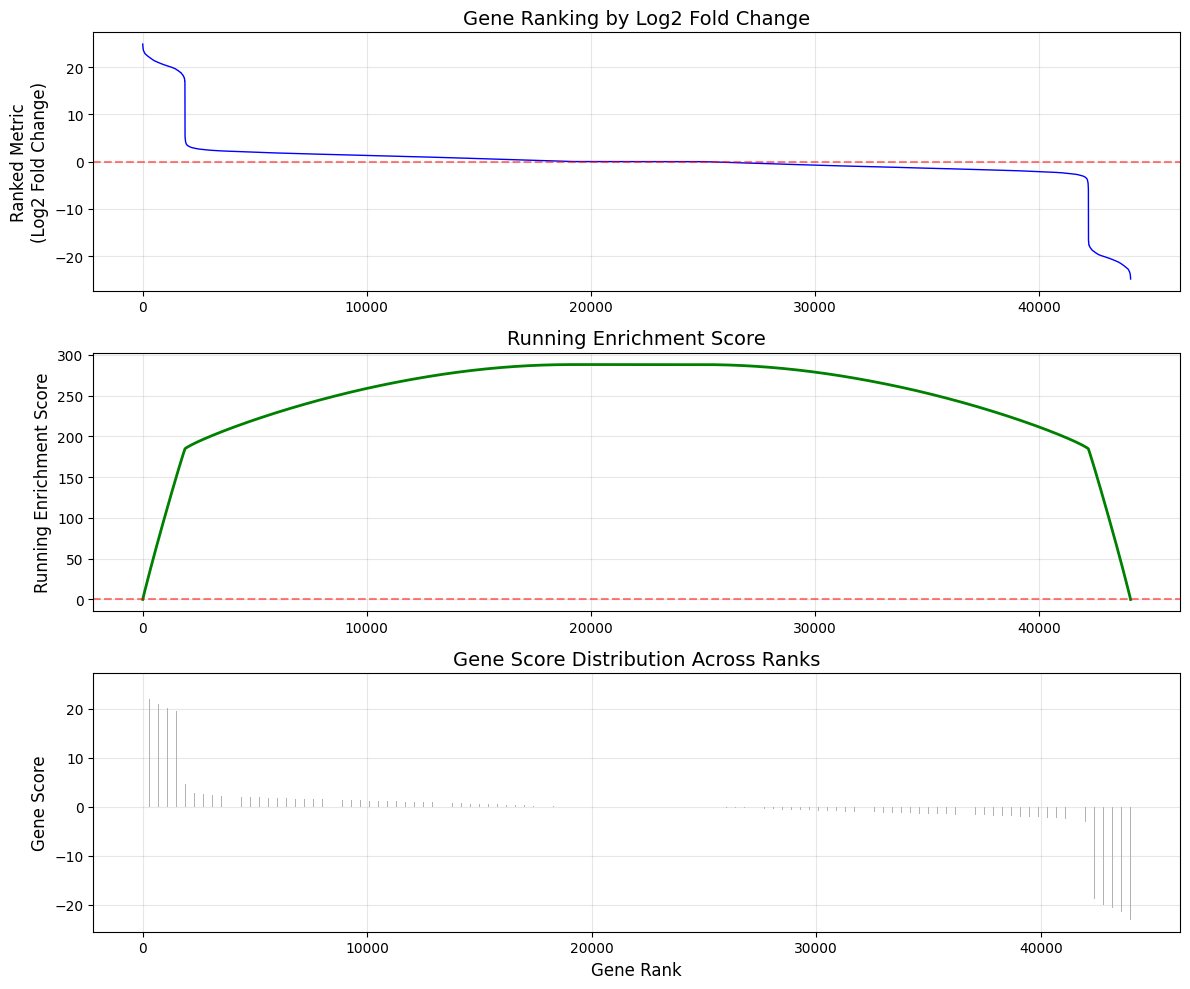

In [ ]:
# Manual creation of enrichment score plot
# This shows gene rank vs enrichment score and ranked metric

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Ranked metric (gene scores)
gene_positions = range(len(gene_rank))
ax1.plot(gene_positions, gene_rank.values, color='blue', linewidth=1)
ax1.set_ylabel('Ranked Metric\n(Log2 Fold Change)', fontsize=12)
ax1.set_title('Gene Ranking by Log2 Fold Change', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Plot 2: Running enrichment score (example for top pathway)
if len(prerank_res.res2d) > 0:
    # Create a simple running enrichment score visualization
    # This is a simplified version - GSEApy has more complex calculations
    running_es = np.cumsum(gene_rank.values) / np.sqrt(len(gene_rank))
    ax2.plot(gene_positions, running_es, color='green', linewidth=2)
    ax2.set_ylabel('Running Enrichment Score', fontsize=12)
    ax2.set_title('Running Enrichment Score', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Plot 3: Gene rank distribution
ax3.bar(gene_positions[::100], gene_rank.values[::100], width=10, alpha=0.6, color='gray')
ax3.set_xlabel('Gene Rank', fontsize=12)
ax3.set_ylabel('Gene Score', fontsize=12)
ax3.set_title('Gene Score Distribution Across Ranks', fontsize=14)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Get significantly upregulated genes for Enrichr analysis
# Filter for significantly upregulated genes
upregulated_genes = de_results[
    (de_results['logfoldchanges'] > 0.5) & 
    (de_results['pvals_adj'] < 0.05)
]['names'].tolist()

print(f"Found {len(upregulated_genes)} significantly upregulated genes")
print("Top 20 upregulated genes:", upregulated_genes[:20])


Found 8139 significantly upregulated genes
Top 20 upregulated genes: ['MKLN1', 'STK3', 'BABAM2', 'QKI', 'PDE8A', 'NF1', 'WWOX', 'FCHSD2', 'NFIA', 'FRS2', 'ANKRD17', 'FAF1', 'MEF2A', 'ZRANB2', 'FAM172A', 'GPHN', 'VPS13B', 'BMPR1A', 'HSD17B4', 'RSRC1']


# 10. UMAPs erstellen

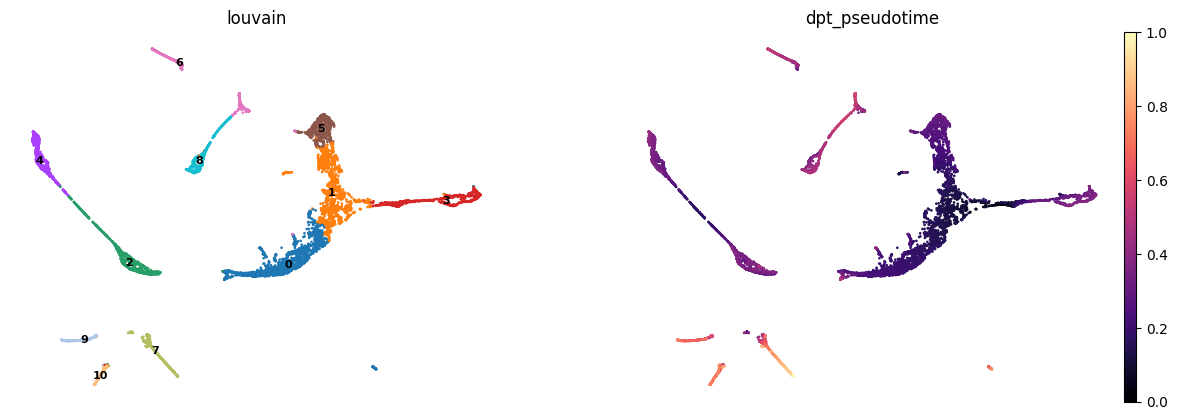

In [41]:
cdata = sc.read_h5ad("data/pyED_correct_soupx.h5ad")
np.random.seed(42) #setze random seed für die reproducibility

sc.pp.normalize_total(cdata, target_sum=1e4)
sc.pp.log1p(cdata)

sc.pp.highly_variable_genes(cdata, min_mean=0.01, max_mean=10, min_disp=0.2)
#sc.pp.scale(cdata, max_value=10)
sc.tl.pca(cdata, n_comps=20, random_state=42)

# 2. Diffusion Maps
sc.pp.neighbors(cdata, n_neighbors=100,n_pcs=20, random_state=42)
sc.tl.diffmap(cdata)
cdata.obsm['X_diffmap'] = cdata.obsm['X_diffmap'][:, 1:15]  # Remove noise component

# 3. UMAP
sc.pp.neighbors(cdata, use_rep='X_diffmap', n_neighbors=100, random_state=42)
sc.tl.umap(cdata, min_dist=0.05, random_state=42)

# 4. Clustering
sc.tl.louvain(cdata, resolution=0.3, random_state=42)

# 5. Pseudotime (DPT)
cdata.uns['iroot'] = np.flatnonzero(cdata.obs['louvain'] == '3')[0]  # Set root cell to cluster 3 == GSTM3
sc.tl.dpt(cdata)             # This adds cdata.obs['dpt_pseudotime']


# Essential spermatogenesis progression markers
key_genes = [
    # Late spermatid/maturation - chromatin condensation
    "PRM1",     # Protamine 1 - main chromatin condensation
    "PRM2",     # Protamine 2 - slightly later chromatin condensation

    # Transition proteins (should precede PRM1/2)
    "TNP1",  # Transition protein 1 - early chromatin condensation (earlier than PRM1/2)
    "TNP2",     # Transition protein 2
    #"SPNB2",    # Spectrin beta 2 ---!!!--- not found in data
    
    # Late spermatid/maturation
    "SPAG16",   # Sperm-associated antigen - flagellum assembly
    "ODF1", "ODF2",  # Outer dense fiber (flagellum)
    "SMCP",     # Sperm mitochondria-associated protein
    "ACRV1",   # Acrosomal vesicle protein
    "CRISP2",   # Cysteine-rich secretory protein
    #"CATSPER1", "CATSPER2",  # Ca2+ channels for motility ---...--- low expression
    
    # Supporting cells
    "CYP17A1", # Leydig steroidogenesis  
    "ACTA2",    # Peritubular myoid cells
    "CLU",    #Sertoli/epididymal
]

sc.pl.umap(cdata, color=['louvain', 'dpt_pseudotime'], ncols=2, legend_loc="on data", legend_fontsize=8, frameon=False, cmap="magma") 

print_components = False

if print_components:
    for i in range(0, math.ceil(len(key_genes)/2)):
        sc.pl.umap(cdata, color=key_genes[i*2: i*2+2], cmap="coolwarm", size=6, ncols=2, frameon=False)

# PRM2 war interessant im vergleich zu PRM1, da es erst bei Reifung der spermien auftritt. 
# hihe PRM1 konzentration bedeutet das die Chromatin Kondensation startet. Entsprechend da sollte auch TSSK6 hoch sein, welches für 
# spezifische modifikationen wie die Phosphorylierung zuständig ist.


### DPT pseudotime interpretation:
Values: 0 to ~1+ where:
    0 = root/starting cells (most undifferentiated)
    Higher values = more differentiated/later in trajectory

müsste folgendes Meaning haben soweit ich es verstanden habe:
    Low pseudotime: Spermatogonial stem cells
    Medium:         Spermatocytes (meiosis)
    High:           Spermatids (post-meiotic)

## get Cluster Names

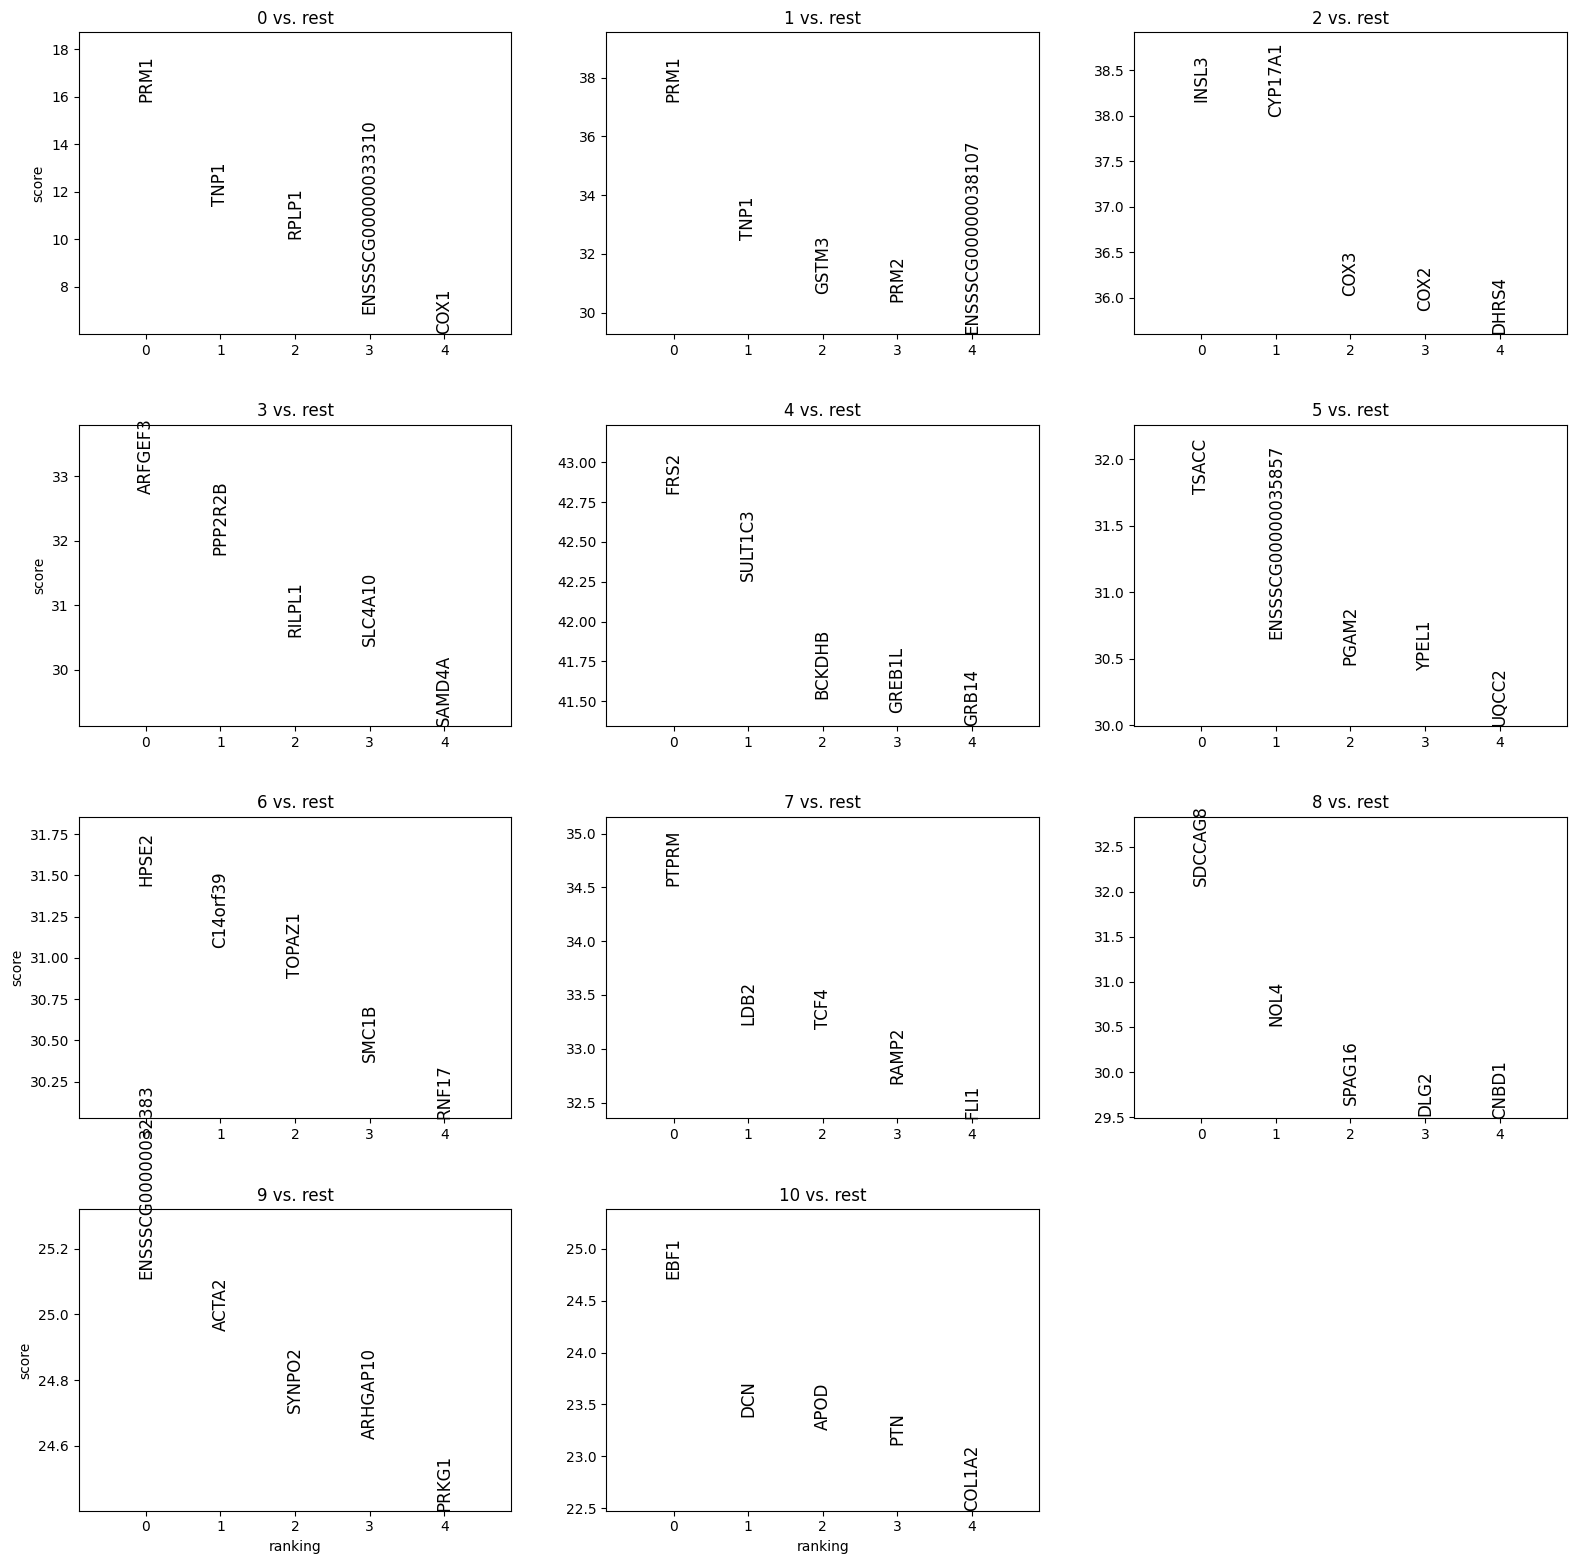

In [42]:
# so lets find marker genes for each cluster yayy
sc.tl.rank_genes_groups(cdata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(cdata, 
                        n_genes=5, 
                        sharey=False, 
                        ncols=3, 
                        fontsize=12
                        )


/var/folders/06/zfzddxwn4hd0ywccb30sl4qw0000gn/T/ipykernel_5263/1940312643.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_markers = marker_genes.groupby('group').first()['names']


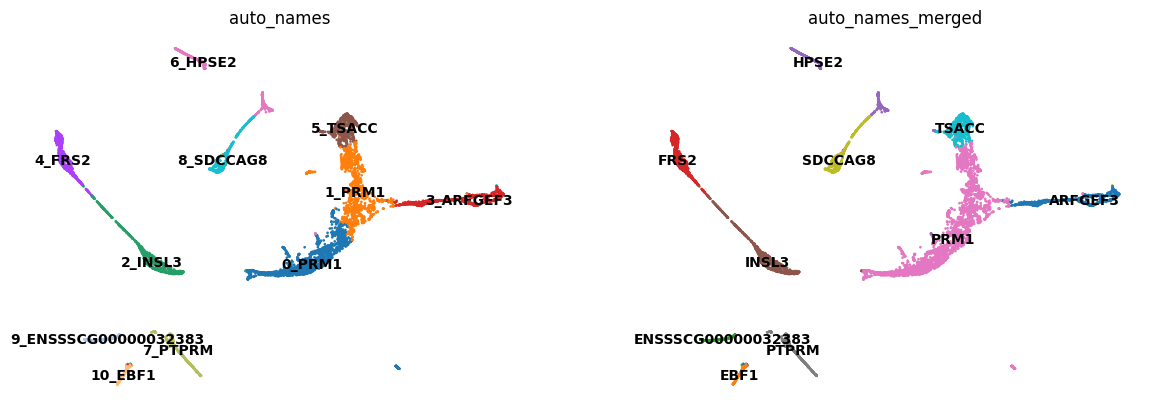

In [43]:
# Get top marker gene per cluster and use as name
marker_genes = sc.get.rank_genes_groups_df(cdata, group=None)
top_markers = marker_genes.groupby('group').first()['names']

cdata.obs['auto_names'] = cdata.obs['louvain'].astype(str) + '_' + cdata.obs['louvain'].map(top_markers).astype(str)
cdata.obs['auto_names_merged'] = cdata.obs['louvain'].map(top_markers)
sc.pl.umap(cdata, color=['auto_names','auto_names_merged'], legend_loc='on data', legend_fontsize=10
           , frameon=False, cmap='magma')
 #'auto_names_merged'

In [44]:
print(top_markers)

group
0                   PRM1
1                   PRM1
2                  INSL3
3                ARFGEF3
4                   FRS2
5                  TSACC
6                  HPSE2
7                  PTPRM
8                SDCCAG8
9     ENSSSCG00000032383
10                  EBF1
Name: names, dtype: object


## Leiden anstelle von louvain

In [45]:
sc.tl.leiden(
    cdata,
    resolution=0.6,     # Start medium, adjust as needed
    key_added='leiden_continuum'
)


marker_genes_test = ['PRM1', 'PRM2', 'TNP1', 'TNP2', 'SPAG16', 'ODF1', 'ODF2', 
                'SMCP', 'ACRV1', 'CRISP2', 'CYP17A1', 'ACTA2', 'CLU']

# Dotplot für Cluster-Identität
sc.pl.dotplot(cdata, var_names=marker_genes_test, groupby='leiden')

# UMAP mit Markern farbkodieren (z. B. PRM1 für runde Spermien)
sc.pl.umap(cdata, color=['leiden'] + marker_genes_test, ncols=3, frameon=False)


ValueError: groupby has to be a valid observation. Given leiden, is not in observations: ['louvain', 'dpt_pseudotime', 'auto_names', 'auto_names_merged', 'leiden_continuum']

## analyse Clusters

### tracksplot

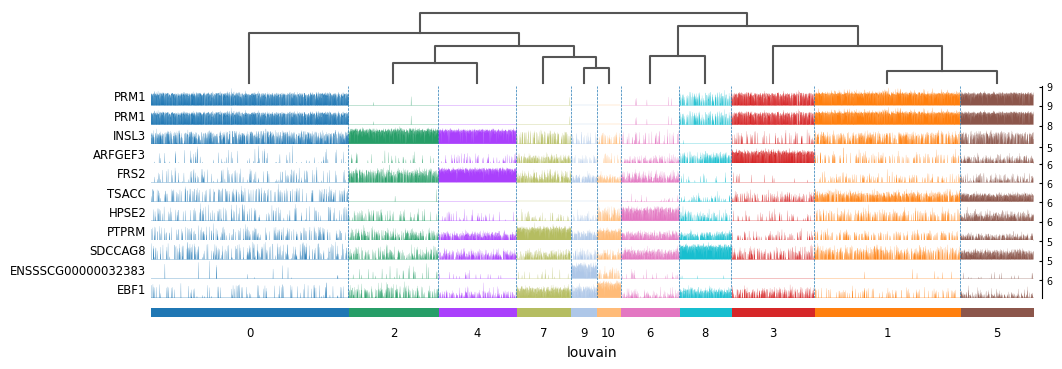

TypeError: '<' not supported between instances of 'float' and 'str'

In [46]:
sc.pl.tracksplot(cdata, var_names=top_markers.values.tolist(), groupby='louvain', 
                 dendrogram=True)

#marker_genes = ['PRM1', 'TNP1', 'SYCP3', 'DDX4']  # Replace with your markers
sc.pl.tracksplot(cdata, var_names=marker_genes, groupby='louvain')

sc.pl.tracksplot(cdata, var_names=top_markers.values.tolist(), groupby='louvain', 
                 order_by=['dpt_pseudotime'])

### fancy dotplot

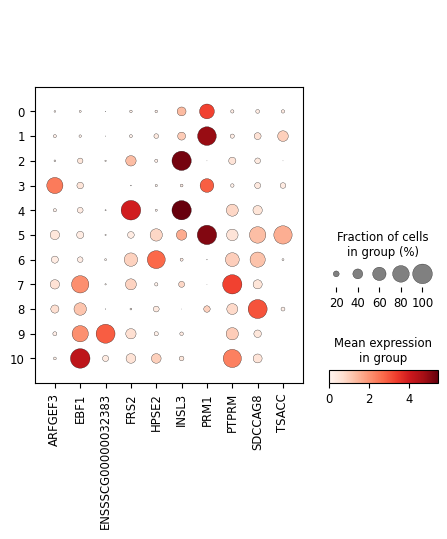

In [47]:
# write in var_names the cluster number and the top_marker names
# only take unique values, to prevent double entries (like PRM1)

top_markers_unique = np.unique(np.array(top_markers.values)).tolist()

sc.pl.dotplot(cdata, 
              var_names=top_markers_unique, 
              groupby='louvain' 
              )

## some single cluster plots

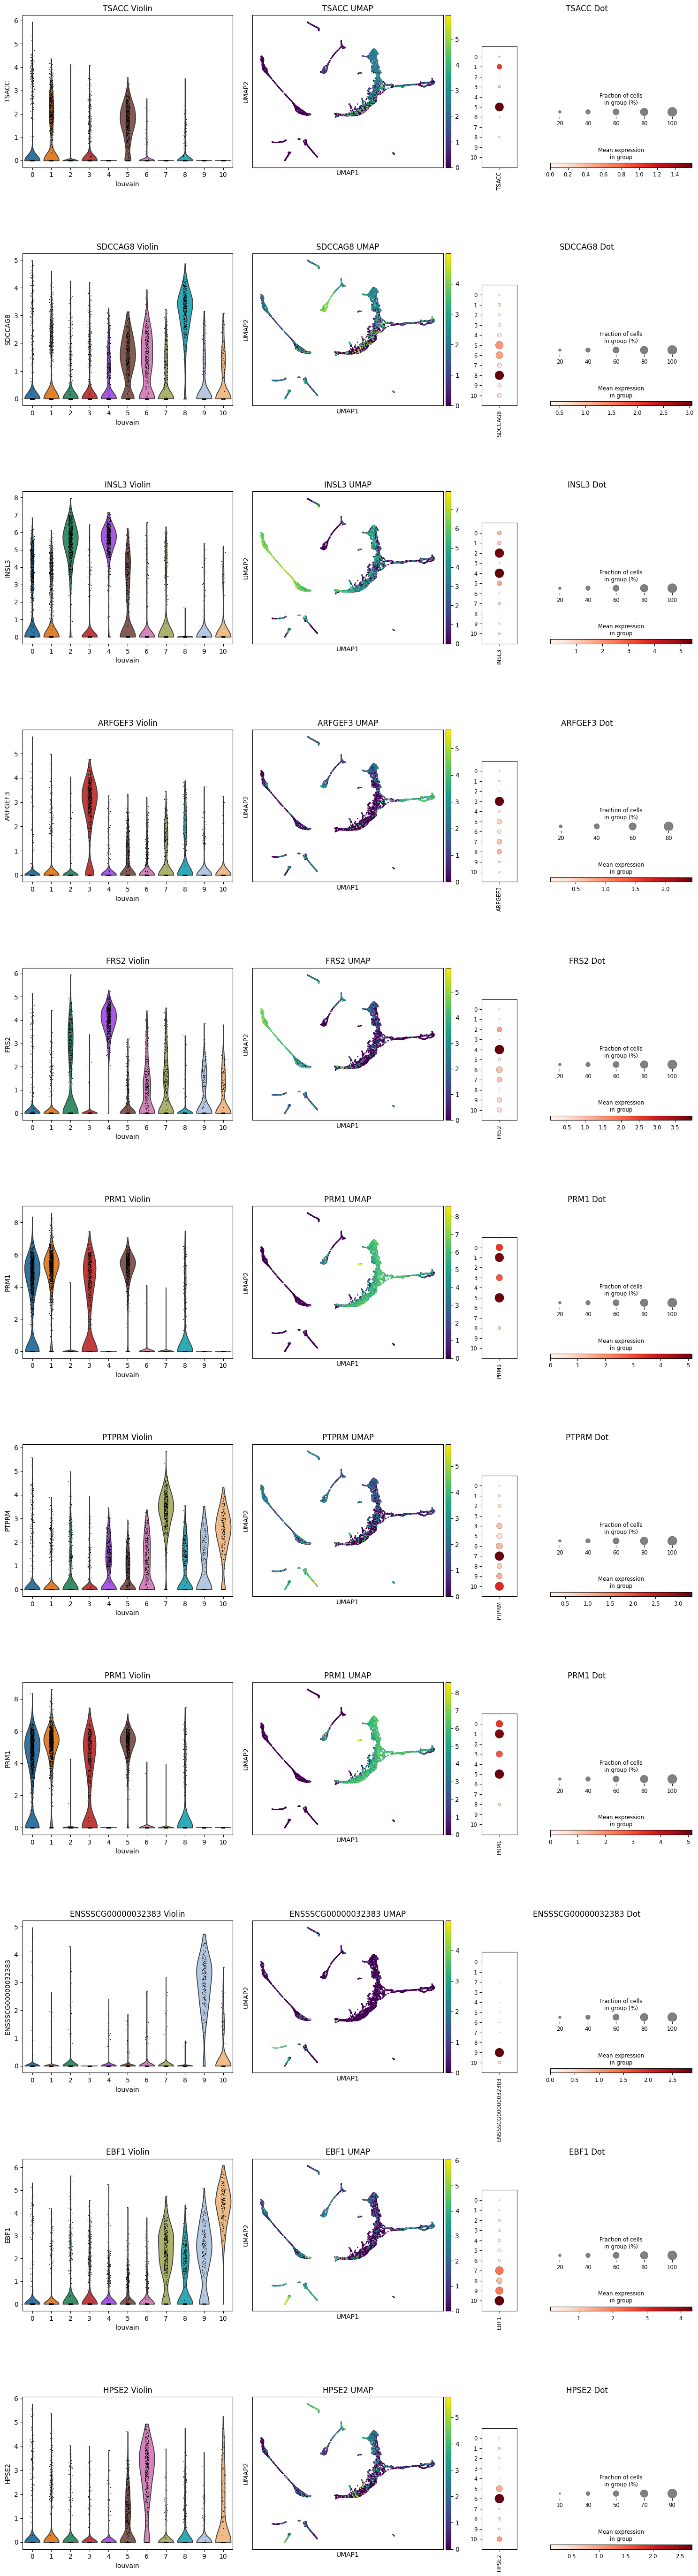

In [48]:
clusters = cdata.obs["louvain"].unique()
n_rows = len(clusters)
fig, axs = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

for i, cluster in enumerate(clusters):
    cluster_name = top_markers[cluster]
    #cluster_mask = cdata.obs["louvain"] == cluster

    # Violin plot
    sc.pl.violin(cdata, keys=cluster_name, groupby='louvain', ax=axs[i,0], show=False)
    axs[i,0].set_title(f'{cluster_name} Violin')
    
    # Feature plot  
    sc.pl.umap(cdata, color=cluster_name, ax=axs[i,1], show=False)
    axs[i,1].set_title(f'{cluster_name} UMAP')
    
    # Dot plot
    sc.pl.dotplot(cdata, var_names=[cluster_name], groupby='louvain', ax=axs[i,2], show=False)
    axs[i,2].set_title(f'{cluster_name} Dot')

plt.tight_layout()
plt.show()

# 20. convert h5 to csv (ED)

This creates two CSV files:
metascape_focused_markers.csv - Complete data with cluster info, fold changes, p-values
metascape_gene_list.csv - Simple single-column CSV with just gene names (perfect for Metascape upload)

In [49]:


# Load your data


# Calculate marker genes for each cluster
sc.tl.rank_genes_groups(cdata, groupby='louvain', method='wilcoxon')
marker_df = sc.get.rank_genes_groups_df(cdata, group=None)

# Filter for significance and effect size
significant_markers = marker_df[
    (marker_df['pvals_adj'] < 0.05) & 
    (marker_df['logfoldchanges'] > 1.0)  # 2-fold change
].groupby('group').head(30)  # Top 30 per cluster

print(f"Total genes for Metascape: {len(significant_markers)}")
print(f"Clusters included: {significant_markers['group'].unique()}")
print(f"Genes per cluster breakdown:")
print(significant_markers['group'].value_counts().sort_index())

# Export as CSV with all information
significant_markers.to_csv("pyED_correct_metascape_focused_markers.csv", index=False)

# Also export just the gene names as a simple CSV (what Metascape typically wants)
gene_list_df = pd.DataFrame({'Gene': significant_markers['names'].tolist()})
gene_list_df.to_csv("pyED_correct_metascape_gene_list.csv", index=False)

# Preview the results
print("\nFirst 10 genes:")
print(significant_markers[['group', 'names', 'logfoldchanges', 'pvals_adj']].head(10))

print(f"\nFiles created:")
print(f"1. metascape_focused_markers.csv - Full marker data with stats")
print(f"2. metascape_gene_list.csv - Simple gene list for Metascape upload")

Total genes for Metascape: 302
Clusters included: ['0', '1', '2', '3', '4', ..., '6', '7', '8', '9', '10']
Length: 11
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']
Genes per cluster breakdown:
group
0      2
1     30
2     30
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
Name: count, dtype: int64

First 10 genes:
      group               names  logfoldchanges      pvals_adj
0         0                PRM1        2.011985   1.287705e-54
1         0                TNP1        1.245139   4.619911e-29
22037     1                PRM1        4.741544  4.774435e-298
22038     1                TNP1        3.733629  1.802044e-227
22039     1               GSTM3        2.767510  5.272192e-202
22040     1                PRM2        3.190583  6.644313e-199
22041     1  ENSSSCG00000038107        2.747598  1.078681e-184
22042     1              COX7A2        2.755057  1.078431e-183
22043     1              CRISP2        2.703262  5.576047e-183
220

/var/folders/06/zfzddxwn4hd0ywccb30sl4qw0000gn/T/ipykernel_5263/2134714806.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  significant_markers = marker_df[


# 21 same but raw + filtered

In [ ]:
def process_and_export_markers(data_path, output_prefix):
    """Process 10x data and export marker genes for Metascape"""
    
    print(f"\n{'='*50}")
    print(f"Processing: {data_path}")
    print(f"Output prefix: {output_prefix}")
    print(f"{'='*50}")
    
    # Load data
    adata = sc.read_10x_h5(data_path)
    # Make gene names unique (correct)
    if not adata.var_names.is_unique:
        adata.var_names_make_unique()
    
    print(f"Data shape: {adata.shape}")
    print(f"Total UMI counts: {adata.X.sum()}")
    
    # Calculate QC metrics first
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    # Basic filtering
    adata = adata[adata.obs.n_genes_by_counts >= 200, :]
    adata = adata[adata.obs.n_genes_by_counts <= 5000, :]
    adata = adata[adata.obs.pct_counts_mt < 20, :]
    sc.pp.filter_genes(adata, min_cells=3)
    print(f"After filtering: {adata.shape}")
    
    # Preprocessing
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    print(f"Highly variable genes: {int(adata.var['highly_variable'].sum())}")
    
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.louvain(adata, resolution=0.5)
    print("Clustering completed!")
    print("Louvain clusters found:", adata.obs['louvain'].value_counts().sort_index())
    
    # Markers
    sc.tl.rank_genes_groups(adata, groupby='louvain', method='wilcoxon')
    marker_df = sc.get.rank_genes_groups_df(adata, group=None)
    
    # Focused set
    significant_markers = marker_df[
        (marker_df['pvals_adj'] < 0.05) & 
        (marker_df['logfoldchanges'] > 1.0)
    ].groupby('group').head(30)
    
    print(f"Total genes for Metascape: {len(significant_markers)}")
    print("Genes per cluster:")
    print(significant_markers['group'].value_counts().sort_index())
    
    # Exports
    significant_markers.to_csv(f"{output_prefix}_focused_markers.csv", index=False)
    pd.DataFrame({'Gene': significant_markers['names'].tolist()}).to_csv(
        f"{output_prefix}_gene_list.csv", index=False
    )
    
    print(f"\nFiles created:")
    print(f"1. {output_prefix}_focused_markers.csv")
    print(f"2. {output_prefix}_gene_list.csv")
    return adata, significant_markers

# Run for both matrices
try:
    filtered_adata, filtered_markers = process_and_export_markers(
        "data/filtered_feature_bc_matrix.h5", "metascape_filtered"
    )
except Exception as e:
    print(f"Error processing filtered matrix: {e}")

try:
    raw_adata, raw_markers = process_and_export_markers(
        "data/raw_feature_bc_matrix.h5", "metascape_raw"
    )
except Exception as e:
    print(f"Error processing raw matrix: {e}")

print("\n====== SUMMARY ======")
if 'filtered_markers' in locals():
    print(f"Filtered: {len(filtered_markers)} genes exported")
if 'raw_markers' in locals():
    print(f"Raw: {len(raw_markers)} genes exported")


Processing: data/filtered_feature_bc_matrix.h5
Output prefix: metascape_filtered


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Data shape: (2701, 22040)
Total UMI counts: 11576431.0
After filtering: (2540, 17768)
Highly variable genes: 4590


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Clustering completed!
Louvain clusters found: louvain
0     514
1     443
2     237
3     219
4     216
5     208
6     199
7     139
8     120
9     104
10     95
11     27
12     19
Name: count, dtype: int64


/var/folders/06/zfzddxwn4hd0ywccb30sl4qw0000gn/T/ipykernel_2849/2499522831.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  significant_markers = marker_df[


Total genes for Metascape: 390
Genes per cluster:
group
0     30
1     30
2     30
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
11    30
12    30
Name: count, dtype: int64

Files created:
1. metascape_filtered_focused_markers.csv
2. metascape_filtered_gene_list.csv

Processing: data/raw_feature_bc_matrix.h5
Output prefix: metascape_raw


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Data shape: (722431, 22040)
Total UMI counts: 35253856.0


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After filtering: (9769, 18649)
Highly variable genes: 4951


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Clustering completed!
Louvain clusters found: louvain
0     2337
1     1901
2     1761
3      954
4      763
5      525
6      490
7      478
8      364
9       81
10      50
11      35
12      30
Name: count, dtype: int64
Total genes for Metascape: 350
Genes per cluster:
group
0     18
1     30
2      2
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
11    30
12    30
Name: count, dtype: int64

Files created:
1. metascape_raw_focused_markers.csv
2. metascape_raw_gene_list.csv

====== SUMMARY ======
Filtered: 390 genes exported
Raw: 350 genes exported


/var/folders/06/zfzddxwn4hd0ywccb30sl4qw0000gn/T/ipykernel_2849/2499522831.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  significant_markers = marker_df[
